### Import all dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import dump

# setup libs
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12,6)

### Load the data from csv file

In [2]:
data = pd.read_csv("./dataset/phishing.csv")

#### Check if data is balanced

<Axes: xlabel='class'>

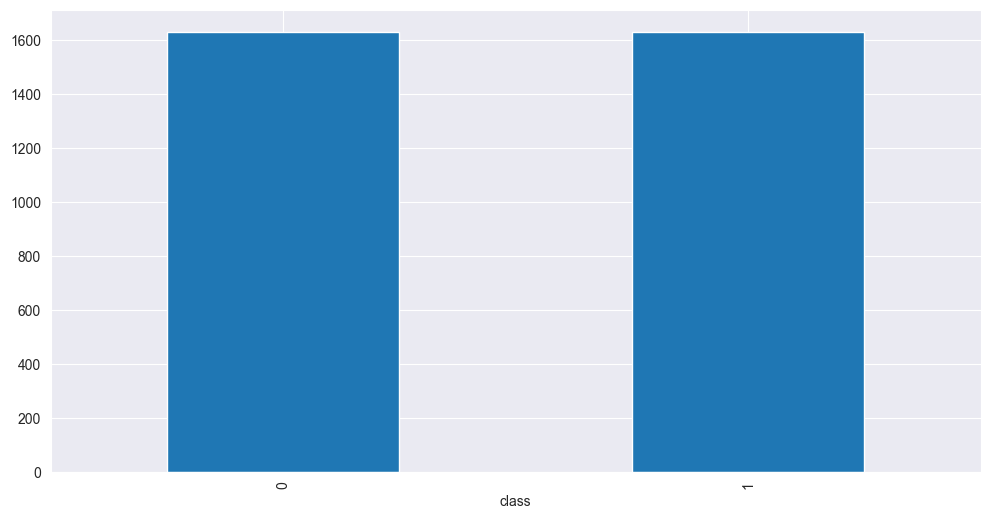

In [3]:
# in case of this dataset the data is balanced 50/50
data['class'].value_counts().plot(kind='bar')

### Sort the data by the most useful columns

In [4]:
X = data.drop(['class'], axis=1)
y = data['class']

discrete_features = X.dtypes == int

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

### Plot scores

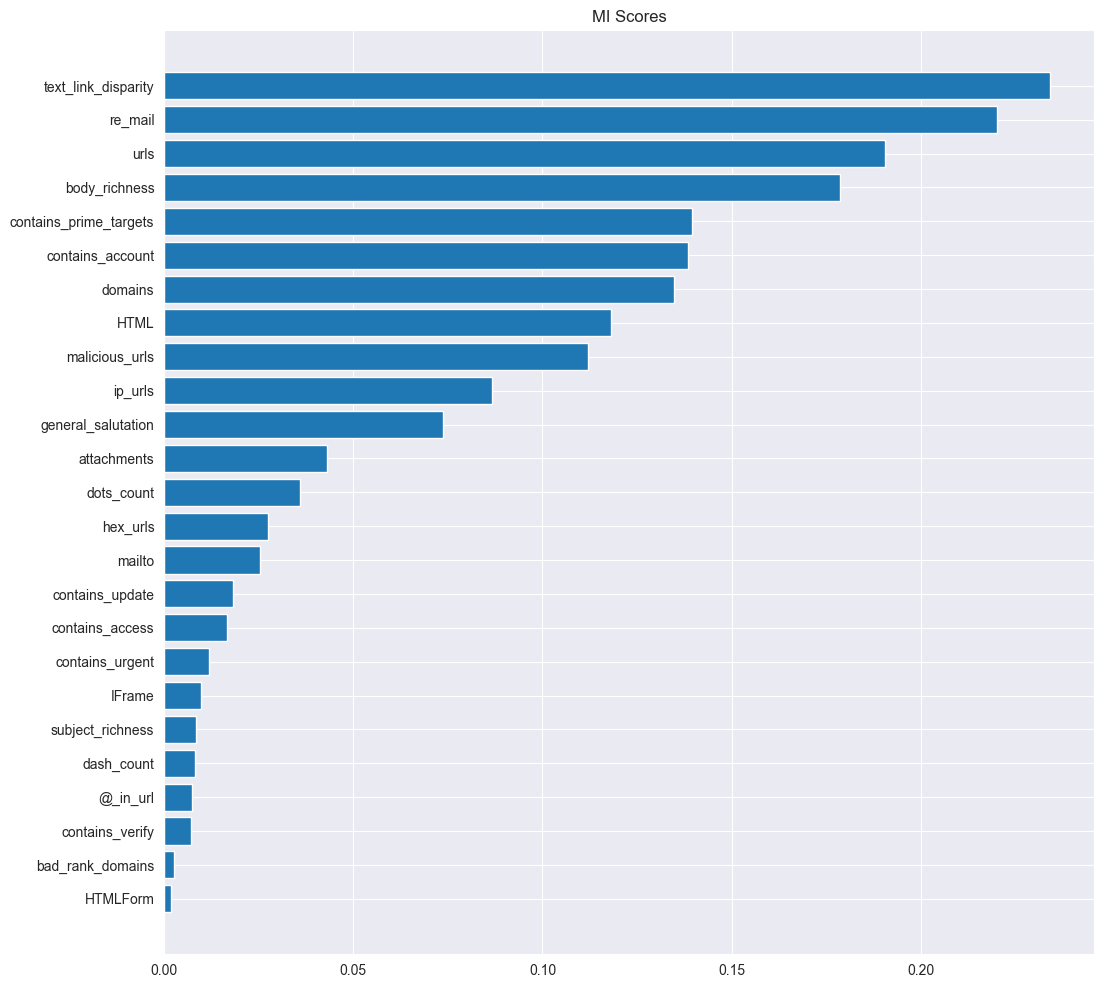

In [5]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores")

plt.figure(dpi=100, figsize=(12,12))
plot_mi_scores(mi_scores)

### Train model for tests

In [6]:
def train_test(features_count):
    features = mi_scores.sort_values(ascending=False).head(features_count).index.tolist()

    X = data[features]
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    rfc = RandomForestClassifier(
        n_estimators=10,
        n_jobs=64
    )

    rfc.fit(X_train, y_train)

    y_pred = rfc.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy

### Try different counts of features

In [7]:
# train considering different number of features to compare and chose the best one
arr = []
for i in range(15,22,1):
    precision, recall, f1, accuracy = train_test(i)
    arr.append([i, precision, recall, f1, accuracy])

df = pd.DataFrame(arr, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])
df.head(30)

,num_of_features,precision,recall,f1_score,accuracy
0,15,0.993808,0.981651,0.987692,0.987749
1,16,0.994083,0.979592,0.986784,0.986217
2,17,0.987578,0.981481,0.984520,0.984686
3,18,0.990566,0.984375,0.987461,0.987749
4,19,0.990854,0.981873,0.986343,0.986217
5,20,0.967846,0.967846,0.967846,0.969372
6,21,0.990654,0.969512,0.979969,0.980092


### Plot training results

<Axes: xlabel='num_of_features', ylabel='precision'>

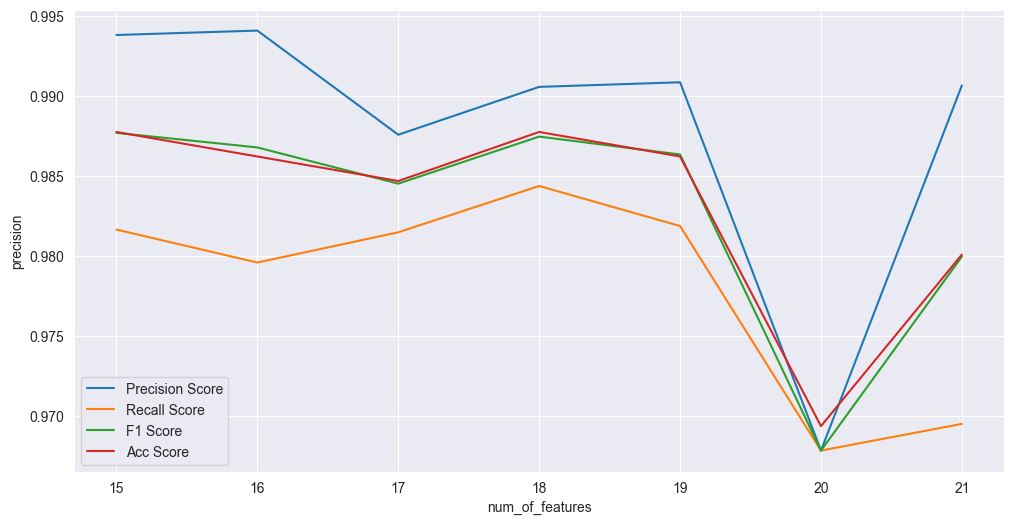

In [8]:
# We can observe that the most efficient number of features is 17
sns.lineplot(x='num_of_features', y='precision', data=df, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df, label='Acc Score')

### Train real model with features count 17

In [9]:
def train():
    features = mi_scores.sort_values(ascending=False).head(17).index.tolist()
    X = data[features]
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    rfc = RandomForestClassifier(
        n_estimators=10,
        n_jobs=64
    )

    rfc.fit(X_train, y_train)

    return rfc

### Save model

In [10]:
# model = train()
# dump(model, "./model/model.joblib")